In [1]:


from itertools import product
from datasets import load_dataset,load_from_disk
import config
import os
import pandas as pd
import util
import torch
import plotting
from scipy.stats import power_divergence

import config
from itertools import product



In [2]:
import os
import pandas as pd
import torch
from itertools import product
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
import threading
from multiprocessing import Manager
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy
stats_lock = threading.Lock()

# Use Manager to create shared cache and stats list
manager = Manager()
dataset_cache = manager.dict()
df_cache = manager.dict()
stats = manager.list()  # Shared list to store stats from all processes

def get_cached_dataset(dataset_name):
    if dataset_name not in dataset_cache:
        print(f"[Dataset] Loading: {dataset_name}")
        dataset_cache[dataset_name] = load_dataset(dataset_name)["train"].select_columns("stage")
    return dataset_cache[dataset_name]

def get_prepared_df(dataset_name, model_type):
    cache_key = (dataset_name, model_type)

    if cache_key not in df_cache:
        print(f"[DataFrame] Preparing for: {dataset_name} / {model_type}")
        
        dataset = get_cached_dataset(dataset_name)
        model_name = dataset_name + "_" + model_type + "_random"
        
        influence_output_dir = os.path.join(
            "./influence_mean_normalized",
            os.path.basename(model_name),
            "_".join([(os.path.basename(dataset_name) + "_" + "train[0%:100%]")] * 2),
        )
        
        df = pd.DataFrame({
            int(result_checkpoint.replace("checkpoint-", "")): torch.load(
                os.path.join(influence_output_dir, result_checkpoint),
                weights_only=True,
                map_location="cpu"
            ).numpy().flatten()
            for result_checkpoint in os.listdir(influence_output_dir)
        })

        df = df.reindex(sorted(df.columns), axis=1)
        df["stage"] = dataset.to_pandas()

        df_cache[cache_key] = df
        print(f"[DataFrame] Cached for: {dataset_name} / {model_type}")
    return df_cache[cache_key]

# Generate combinations
all_combinations = []

for model_type in config.model_types: 
    curricula = [model_type + c for c in config.influence_curricula] + config.baseline_curricula
    for a, b in product(curricula, curricula):
        for dataset in config.datasets:
            all_combinations.append((dataset, model_type, a, b))
print(len(all_combinations))
def process_combination(combination):
    dataset_name, model_type, curriculum_a_name, curriculum_b_name = combination
    local_stats = []

    try:
        df = get_prepared_df(dataset_name, model_type)

        epsilon = 1e-100
        bins = 1000

        curriculum_a = util.get_curriculum(dataset_name, curriculum_a_name)
        curriculum_b = util.get_curriculum(dataset_name, curriculum_b_name)

        examples_a = df.iloc[torch.cat(curriculum_a).flatten()]
        examples_b = df.iloc[torch.cat(curriculum_b).flatten()]

        all_stages = examples_a["stage"].unique()

        max_len = min(len(examples_a), len(examples_b))
        bin_size = max_len // bins

        chunks_to_compare = [
            (examples_a["stage"][i:i+bin_size], examples_b["stage"][i:i+bin_size])
            for i in range(0, max_len, bin_size) if i + bin_size < max_len
        ]
        
        local_stats.extend([
            (
                idx, curriculum_a_name, curriculum_b_name, dataset_name,
                model_type, len(a), len(b),
                jensenshannon(
                    p=a.value_counts().reindex(all_stages, fill_value=epsilon),
                    q=b.value_counts().reindex(all_stages, fill_value=epsilon),
                    
                )**2,
            
                
                
                
            )
            for idx, (a, b) in enumerate(chunks_to_compare)
        ])

    except Exception as e:
        print(f"[Error] Skipping: {dataset_name}, {model_type}, {curriculum_a_name}, {curriculum_b_name}")
        print("Reason:", str(e))
  
    # Append local stats to the shared stats list safely
    with stats_lock:
        stats.extend(local_stats)

# Prepare interleaved batches
import random
from itertools import chain, zip_longest
from collections import defaultdict

cache_path = (os.path.join("./plotting_notebooks/cache/","source_similarity.csv"))

if True or not os.path.exists(cache_path):

    first_batch = all_combinations[:3]
    remaining_batch = all_combinations[3:]

    # Use ThreadPoolExecutor for the first batch
    with ThreadPoolExecutor(max_workers=3) as executor:
        futures = [executor.submit(process_combination, c) for c in first_batch]
        for _ in tqdm(as_completed(futures), total=len(futures), desc="Processing (3 workers)") :
            pass
    print(stats)

    print(len(stats))
    with ProcessPoolExecutor(max_workers=128) as executor:
        futures = [executor.submit(process_combination, c) for c in remaining_batch]
        for _ in tqdm(as_completed(futures), total=len(futures), desc="Processing (64 workers)") :
            pass
    print(len(stats))
    stats_df = pd.DataFrame(list(stats),columns=["chunk","curriculum_a", "curriculum_b","dataset", "model_type", "chunk_size_a", "chunk_size_b", "divergence"])
    stats_df.to_pickle(cache_path)

stats_df = pd.read_pickle(cache_path)

stats_df["curriculum_a"].unique()

1176
[DataFrame] Preparing for: loris3/babylm_2024_10m_curriculum / llama
[Dataset] Loading: loris3/babylm_2024_10m_curriculum
[DataFrame] Preparing for: loris3/stratified_equitoken_10m_curriculum / llama
[DataFrame] Preparing for: loris3/stratified_10m_curriculum / llama
[Dataset] Loading: loris3/stratified_equitoken_10m_curriculum
[Dataset] Loading: loris3/stratified_10m_curriculum


Processing (3 workers):   0%|          | 0/3 [00:00<?, ?it/s]

[DataFrame] Cached for: loris3/stratified_equitoken_10m_curriculum / llama
[DataFrame] Cached for: loris3/stratified_10m_curriculum / llama
[DataFrame] Cached for: loris3/babylm_2024_10m_curriculum / llama


Processing (3 workers): 100%|██████████| 3/3 [00:09<00:00,  3.22s/it]

[(0, 'llama_incr_influence_epoch_repetition.pt', 'llama_incr_influence_epoch_repetition.pt', 'loris3/stratified_equitoken_10m_curriculum', 'llama', 1000, 1000, 0.0), (1, 'llama_incr_influence_epoch_repetition.pt', 'llama_incr_influence_epoch_repetition.pt', 'loris3/stratified_equitoken_10m_curriculum', 'llama', 1000, 1000, 0.0), (2, 'llama_incr_influence_epoch_repetition.pt', 'llama_incr_influence_epoch_repetition.pt', 'loris3/stratified_equitoken_10m_curriculum', 'llama', 1000, 1000, 0.0), (3, 'llama_incr_influence_epoch_repetition.pt', 'llama_incr_influence_epoch_repetition.pt', 'loris3/stratified_equitoken_10m_curriculum', 'llama', 1000, 1000, 0.0), (4, 'llama_incr_influence_epoch_repetition.pt', 'llama_incr_influence_epoch_repetition.pt', 'loris3/stratified_equitoken_10m_curriculum', 'llama', 1000, 1000, 0.0), (5, 'llama_incr_influence_epoch_repetition.pt', 'llama_incr_influence_epoch_repetition.pt', 'loris3/stratified_equitoken_10m_curriculum', 'llama', 1000, 1000, 0.0), (6, 'llam


Processing (64 workers):  39%|███▉      | 463/1173 [01:50<00:56, 12.57it/s]

[DataFrame] Preparing for: loris3/babylm_2024_10m_curriculum / roberta
[DataFrame] Preparing for: loris3/stratified_equitoken_10m_curriculum / roberta[DataFrame] Preparing for: loris3/stratified_10m_curriculum / roberta

[DataFrame] Preparing for: loris3/babylm_2024_10m_curriculum / roberta
[DataFrame] Preparing for: loris3/babylm_2024_10m_curriculum / roberta


Processing (64 workers):  40%|███▉      | 465/1173 [01:51<01:49,  6.46it/s]

[DataFrame] Preparing for: loris3/stratified_equitoken_10m_curriculum / roberta
[DataFrame] Preparing for: loris3/stratified_10m_curriculum / roberta


Processing (64 workers):  40%|███▉      | 467/1173 [01:51<01:41,  6.98it/s]

[DataFrame] Preparing for: loris3/babylm_2024_10m_curriculum / roberta[DataFrame] Preparing for: loris3/stratified_equitoken_10m_curriculum / roberta



Processing (64 workers):  40%|████      | 473/1173 [01:53<03:09,  3.70it/s]

[DataFrame] Preparing for: loris3/stratified_equitoken_10m_curriculum / roberta


Processing (64 workers):  40%|████      | 474/1173 [01:53<03:27,  3.37it/s]

[DataFrame] Preparing for: loris3/babylm_2024_10m_curriculum / roberta


Processing (64 workers):  40%|████      | 475/1173 [01:54<03:28,  3.34it/s]

[DataFrame] Preparing for: loris3/stratified_10m_curriculum / roberta


Processing (64 workers):  41%|████      | 476/1173 [01:54<02:54,  4.00it/s]

[DataFrame] Preparing for: loris3/stratified_equitoken_10m_curriculum / roberta


Processing (64 workers):  41%|████      | 478/1173 [01:55<04:50,  2.39it/s]

[DataFrame] Preparing for: loris3/stratified_equitoken_10m_curriculum / roberta[DataFrame] Preparing for: loris3/stratified_10m_curriculum / roberta[DataFrame] Preparing for: loris3/stratified_equitoken_10m_curriculum / roberta




Processing (64 workers):  41%|████      | 480/1173 [01:55<03:49,  3.01it/s]

[DataFrame] Preparing for: loris3/stratified_10m_curriculum / roberta[DataFrame] Preparing for: loris3/babylm_2024_10m_curriculum / roberta



Processing (64 workers):  41%|████      | 482/1173 [01:56<03:02,  3.79it/s]

[DataFrame] Preparing for: loris3/babylm_2024_10m_curriculum / roberta

Processing (64 workers):  41%|████▏     | 485/1173 [01:56<01:54,  6.01it/s]

[DataFrame] Preparing for: loris3/stratified_10m_curriculum / roberta



Processing (64 workers):  42%|████▏     | 487/1173 [01:56<01:38,  6.97it/s]

[DataFrame] Preparing for: loris3/stratified_equitoken_10m_curriculum / roberta

Processing (64 workers):  42%|████▏     | 489/1173 [01:56<01:29,  7.61it/s]

Processing (64 workers):  42%|████▏     | 491/1173 [01:56<01:15,  9.09it/s]

[DataFrame] Preparing for: loris3/stratified_equitoken_10m_curriculum / roberta[DataFrame] Preparing for: loris3/babylm_2024_10m_curriculum / roberta[DataFrame] Preparing for: loris3/stratified_10m_curriculum / roberta[DataFrame] Preparing for: loris3/stratified_equitoken_10m_curriculum / roberta





Processing (64 workers):  42%|████▏     | 493/1173 [01:56<01:03, 10.65it/s]

[DataFrame] Preparing for: loris3/stratified_10m_curriculum / roberta
[DataFrame] Preparing for: loris3/babylm_2024_10m_curriculum / roberta

Processing (64 workers):  42%|████▏     | 495/1173 [01:56<00:57, 11.89it/s]


[DataFrame] Preparing for: loris3/babylm_2024_10m_curriculum / roberta

Processing (64 workers):  42%|████▏     | 497/1173 [01:57<00:52, 13.00it/s]


[DataFrame] Preparing for: loris3/stratified_10m_curriculum / roberta
[DataFrame] Cached for: loris3/stratified_equitoken_10m_curriculum / roberta
[DataFrame] Preparing for: loris3/babylm_2024_10m_curriculum / roberta
[DataFrame] Preparing for: loris3/stratified_10m_curriculum / roberta

Processing (64 workers):  43%|████▎     | 499/1173 [01:57<01:32,  7.33it/s]


[DataFrame] Preparing for: loris3/stratified_10m_curriculum / roberta
[DataFrame] Preparing for: loris3/stratified_10m_curriculum / roberta
[DataFrame] Preparing for: loris3/babylm_2024_10m_curriculum / roberta
[DataFrame] Preparing for: loris3/stratified_10m_curriculum / roberta


Processing (64 workers):  43%|████▎     | 502/1173 [01:58<02:01,  5.50it/s]

[DataFrame] Preparing for: loris3/stratified_10m_curriculum / roberta


Processing (64 workers):  43%|████▎     | 504/1173 [01:58<01:40,  6.68it/s]

[DataFrame] Preparing for: loris3/babylm_2024_10m_curriculum / roberta


Processing (64 workers):  43%|████▎     | 506/1173 [01:59<02:19,  4.78it/s]

[DataFrame] Preparing for: loris3/babylm_2024_10m_curriculum / roberta[DataFrame] Preparing for: loris3/babylm_2024_10m_curriculum / roberta

[DataFrame] Preparing for: loris3/stratified_10m_curriculum / roberta
[DataFrame] Preparing for: loris3/babylm_2024_10m_curriculum / roberta

Processing (64 workers):  43%|████▎     | 509/1173 [01:59<01:35,  6.98it/s]

[DataFrame] Preparing for: loris3/babylm_2024_10m_curriculum / roberta

[DataFrame] Preparing for: loris3/babylm_2024_10m_curriculum / roberta


Processing (64 workers):  43%|████▎     | 510/1173 [01:59<02:14,  4.91it/s]

[DataFrame] Preparing for: loris3/stratified_10m_curriculum / roberta[DataFrame] Cached for: loris3/stratified_equitoken_10m_curriculum / roberta


Processing (64 workers):  44%|████▍     | 514/1173 [02:00<01:16,  8.60it/s]


[DataFrame] Preparing for: loris3/stratified_10m_curriculum / roberta[DataFrame] Preparing for: loris3/babylm_2024_10m_curriculum / roberta
[DataFrame] Cached for: loris3/stratified_equitoken_10m_curriculum / roberta



Processing (64 workers):  44%|████▍     | 517/1173 [02:00<01:33,  7.03it/s]

[DataFrame] Cached for: loris3/stratified_equitoken_10m_curriculum / roberta
[DataFrame] Preparing for: loris3/babylm_2024_10m_curriculum / roberta[DataFrame] Preparing for: loris3/stratified_10m_curriculum / roberta

[DataFrame] Preparing for: loris3/stratified_10m_curriculum / roberta


Processing (64 workers):  44%|████▍     | 520/1173 [02:02<02:46,  3.93it/s]

[DataFrame] Preparing for: loris3/stratified_10m_curriculum / roberta
[DataFrame] Preparing for: loris3/babylm_2024_10m_curriculum / roberta
[DataFrame] Cached for: loris3/stratified_equitoken_10m_curriculum / roberta


Processing (64 workers):  44%|████▍     | 521/1173 [02:03<04:12,  2.58it/s]

[DataFrame] Cached for: loris3/stratified_equitoken_10m_curriculum / roberta
[DataFrame] Preparing for: loris3/babylm_2024_10m_curriculum / roberta
[DataFrame] Preparing for: loris3/stratified_10m_curriculum / roberta


Processing (64 workers):  45%|████▍     | 527/1173 [02:05<03:17,  3.27it/s]

[DataFrame] Preparing for: loris3/stratified_10m_curriculum / roberta
[DataFrame] Preparing for: loris3/stratified_10m_curriculum / roberta


Processing (64 workers):  45%|████▌     | 529/1173 [02:05<02:25,  4.43it/s]

[DataFrame] Preparing for: loris3/stratified_10m_curriculum / roberta
[DataFrame] Preparing for: loris3/babylm_2024_10m_curriculum / roberta

Processing (64 workers):  45%|████▌     | 530/1173 [02:05<02:29,  4.31it/s]


[DataFrame] Cached for: loris3/stratified_equitoken_10m_curriculum / roberta


Processing (64 workers):  45%|████▌     | 531/1173 [02:06<03:21,  3.19it/s]

[DataFrame] Preparing for: loris3/babylm_2024_10m_curriculum / roberta


Processing (64 workers):  45%|████▌     | 532/1173 [02:06<03:03,  3.49it/s]

[DataFrame] Cached for: loris3/babylm_2024_10m_curriculum / roberta[DataFrame] Cached for: loris3/babylm_2024_10m_curriculum / roberta



Processing (64 workers):  46%|████▌     | 535/1173 [02:07<03:16,  3.24it/s]

[DataFrame] Cached for: loris3/stratified_10m_curriculum / roberta


Processing (64 workers):  46%|████▌     | 541/1173 [02:08<02:33,  4.13it/s]

[DataFrame] Cached for: loris3/stratified_equitoken_10m_curriculum / roberta


Processing (64 workers):  46%|████▌     | 542/1173 [02:09<02:49,  3.72it/s]

[DataFrame] Cached for: loris3/stratified_10m_curriculum / roberta


Processing (64 workers):  47%|████▋     | 555/1173 [02:10<01:08,  9.05it/s]

[DataFrame] Cached for: loris3/stratified_10m_curriculum / roberta
[DataFrame] Cached for: loris3/babylm_2024_10m_curriculum / roberta


Processing (64 workers):  48%|████▊     | 563/1173 [02:11<00:57, 10.57it/s]

[DataFrame] Cached for: loris3/stratified_equitoken_10m_curriculum / roberta
[DataFrame] Cached for: loris3/babylm_2024_10m_curriculum / roberta


Processing (64 workers):  48%|████▊     | 567/1173 [02:11<00:46, 13.09it/s]

[DataFrame] Cached for: loris3/babylm_2024_10m_curriculum / roberta
[DataFrame] Cached for: loris3/stratified_10m_curriculum / roberta


Processing (64 workers):  49%|████▉     | 576/1173 [02:12<00:42, 13.90it/s]

[DataFrame] Cached for: loris3/stratified_10m_curriculum / roberta


Processing (64 workers):  49%|████▉     | 578/1173 [02:12<00:43, 13.72it/s]

[DataFrame] Cached for: loris3/babylm_2024_10m_curriculum / roberta


Processing (64 workers):  50%|████▉     | 582/1173 [02:13<01:19,  7.42it/s]

[DataFrame] Cached for: loris3/babylm_2024_10m_curriculum / roberta
[DataFrame] Cached for: loris3/babylm_2024_10m_curriculum / roberta[DataFrame] Cached for: loris3/babylm_2024_10m_curriculum / roberta

[DataFrame] Cached for: loris3/stratified_10m_curriculum / roberta


Processing (64 workers):  50%|████▉     | 585/1173 [02:13<00:57, 10.26it/s]

[DataFrame] Cached for: loris3/stratified_equitoken_10m_curriculum / roberta


Processing (64 workers):  50%|█████     | 592/1173 [02:13<00:32, 18.01it/s]

[DataFrame] Cached for: loris3/babylm_2024_10m_curriculum / roberta
[DataFrame] Cached for: loris3/babylm_2024_10m_curriculum / roberta

Processing (64 workers):  51%|█████     | 595/1173 [02:14<01:04,  8.97it/s]

Processing (64 workers):  51%|█████     | 597/1173 [02:15<02:00,  4.77it/s]

[DataFrame] Cached for: loris3/stratified_10m_curriculum / roberta
[DataFrame] Cached for: loris3/babylm_2024_10m_curriculum / roberta
[DataFrame] Cached for: loris3/stratified_10m_curriculum / roberta
[DataFrame] Cached for: loris3/babylm_2024_10m_curriculum / roberta


Processing (64 workers):  53%|█████▎    | 617/1173 [02:22<02:21,  3.94it/s]

[DataFrame] Cached for: loris3/stratified_10m_curriculum / roberta


Processing (64 workers):  53%|█████▎    | 619/1173 [02:22<02:33,  3.60it/s]

[DataFrame] Cached for: loris3/babylm_2024_10m_curriculum / roberta


Processing (64 workers):  53%|█████▎    | 624/1173 [02:24<02:46,  3.29it/s]

[DataFrame] Cached for: loris3/stratified_10m_curriculum / roberta


Processing (64 workers):  54%|█████▍    | 632/1173 [02:28<03:22,  2.68it/s]

[DataFrame] Cached for: loris3/stratified_10m_curriculum / roberta


Processing (64 workers):  54%|█████▍    | 633/1173 [02:28<03:35,  2.51it/s]

[DataFrame] Cached for: loris3/stratified_10m_curriculum / roberta


Processing (64 workers):  55%|█████▍    | 640/1173 [02:30<02:21,  3.76it/s]

[DataFrame] Cached for: loris3/stratified_10m_curriculum / roberta


Processing (64 workers):  55%|█████▌    | 646/1173 [02:31<01:22,  6.40it/s]

[DataFrame] Cached for: loris3/stratified_10m_curriculum / roberta


Processing (64 workers):  55%|█████▌    | 651/1173 [02:32<01:41,  5.14it/s]

[DataFrame] Cached for: loris3/stratified_10m_curriculum / roberta


Processing (64 workers):  56%|█████▌    | 654/1173 [02:33<01:58,  4.38it/s]

[DataFrame] Cached for: loris3/babylm_2024_10m_curriculum / roberta


Processing (64 workers):  56%|█████▌    | 658/1173 [02:34<01:39,  5.18it/s]

[DataFrame] Cached for: loris3/stratified_10m_curriculum / roberta


Processing (64 workers):  57%|█████▋    | 665/1173 [02:35<01:45,  4.84it/s]

[DataFrame] Cached for: loris3/stratified_10m_curriculum / roberta

Processing (64 workers):  57%|█████▋    | 666/1173 [02:35<01:50,  4.60it/s]

Processing (64 workers):  60%|██████    | 706/1173 [02:43<01:08,  6.80it/s]

[DataFrame] Cached for: loris3/babylm_2024_10m_curriculum / roberta


Processing (64 workers):  60%|██████    | 707/1173 [02:43<02:05,  3.73it/s]

[DataFrame] Cached for: loris3/stratified_10m_curriculum / roberta


Processing (64 workers):  61%|██████    | 715/1173 [02:44<01:05,  7.01it/s]

[DataFrame] Cached for: loris3/stratified_10m_curriculum / roberta


Processing (64 workers):  63%|██████▎   | 744/1173 [02:53<01:42,  4.18it/s]

[DataFrame] Cached for: loris3/stratified_10m_curriculum / roberta


Processing (64 workers):  69%|██████▉   | 807/1173 [03:08<01:15,  4.84it/s]

[DataFrame] Cached for: loris3/babylm_2024_10m_curriculum / roberta


Processing (64 workers):  73%|███████▎  | 857/1173 [03:17<00:46,  6.86it/s]

[DataFrame] Cached for: loris3/babylm_2024_10m_curriculum / roberta


Processing (64 workers):  77%|███████▋  | 901/1173 [03:27<01:23,  3.27it/s]

[DataFrame] Cached for: loris3/babylm_2024_10m_curriculum / roberta


Processing (64 workers):  77%|███████▋  | 907/1173 [03:28<00:54,  4.92it/s]

[DataFrame] Cached for: loris3/stratified_10m_curriculum / roberta

Processing (64 workers):  77%|███████▋  | 908/1173 [03:28<00:51,  5.11it/s]

Processing (64 workers):  85%|████████▌ | 1000/1173 [03:50<01:40,  1.73it/s]

[DataFrame] Cached for: loris3/stratified_10m_curriculum / roberta


Processing (64 workers):  86%|████████▌ | 1009/1173 [03:54<01:04,  2.56it/s]

[DataFrame] Cached for: loris3/babylm_2024_10m_curriculum / roberta


Processing (64 workers):  88%|████████▊ | 1033/1173 [03:56<00:30,  4.64it/s]

[DataFrame] Cached for: loris3/stratified_10m_curriculum / roberta


Processing (64 workers):  92%|█████████▏| 1082/1173 [04:05<00:10,  8.57it/s]

[DataFrame] Cached for: loris3/stratified_10m_curriculum / roberta


Processing (64 workers):  94%|█████████▍| 1101/1173 [04:07<00:11,  6.15it/s]

[DataFrame] Cached for: loris3/babylm_2024_10m_curriculum / roberta
[DataFrame] Cached for: loris3/babylm_2024_10m_curriculum / roberta[DataFrame] Cached for: loris3/babylm_2024_10m_curriculum / roberta



Processing (64 workers):  94%|█████████▍| 1104/1173 [04:08<00:14,  4.76it/s]

[DataFrame] Cached for: loris3/babylm_2024_10m_curriculum / roberta


Processing (64 workers): 100%|██████████| 1173/1173 [04:18<00:00,  4.54it/s]


1175608


array(['llama_incr_influence_epoch_repetition.pt',
       'llama_influence_decr_bins_dirac.pt',
       'llama_influence_epoch_repetition.pt',
       'llama_influence_incr_bins_lognorm.pt',
       'llama_influence_incr_bins_dirac.pt',
       'llama_influence_decr_bins_lognorm.pt',
       'llama_influence_incr_cp_dirac.pt',
       'llama_influence_decr_cp_dirac.pt',
       'llama_influence_top_50_cp_shuffled.pt',
       'llama_influence_tracin_sandwich.pt', 'random.pt',
       'source_difficulty.pt', 'mattr_increasing.pt',
       'perplexity_increasing.pt',
       'roberta_incr_influence_epoch_repetition.pt',
       'roberta_influence_epoch_repetition.pt',
       'roberta_influence_incr_bins_dirac.pt',
       'roberta_influence_decr_bins_dirac.pt',
       'roberta_influence_incr_bins_lognorm.pt',
       'roberta_influence_decr_bins_lognorm.pt',
       'roberta_influence_incr_cp_dirac.pt',
       'roberta_influence_decr_cp_dirac.pt',
       'roberta_influence_top_50_cp_shuffled.pt',
     

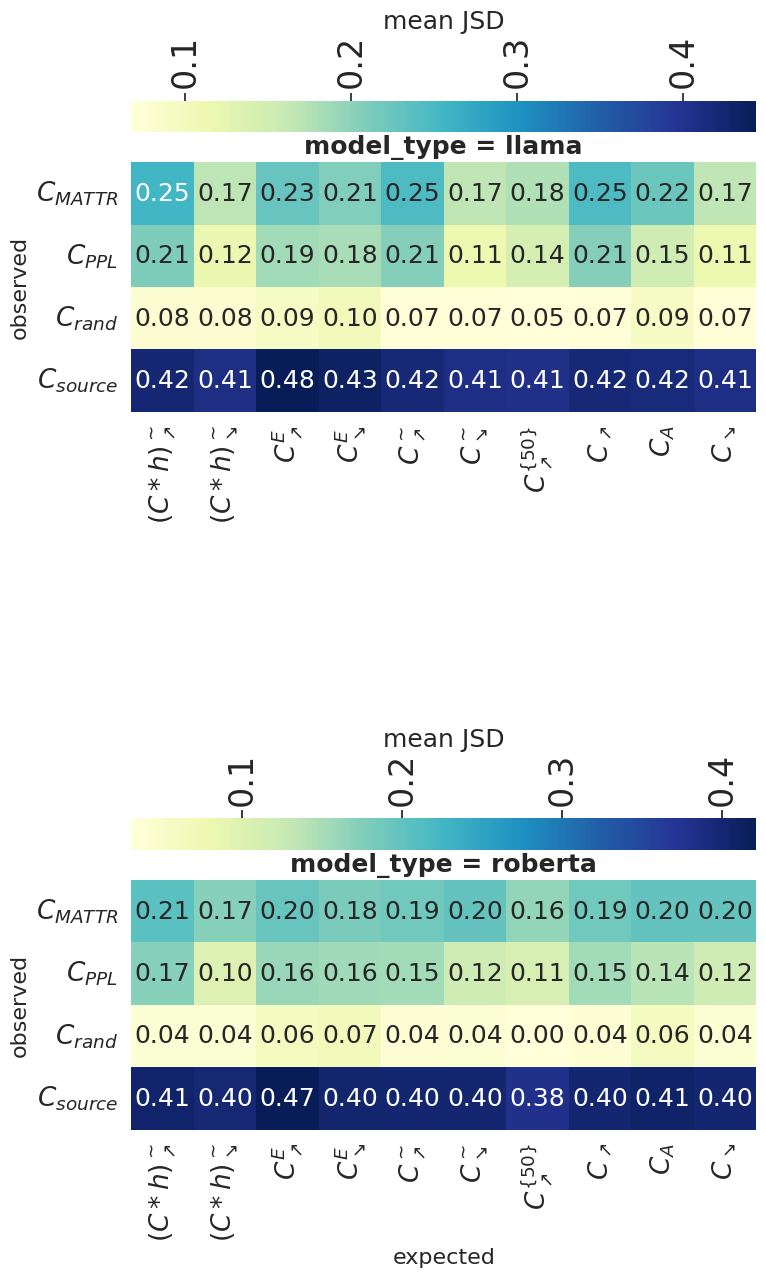

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np




sns.set(font_scale=1.5)

g = sns.FacetGrid(stats_df, row="model_type", height=8, sharex=False)

def plot_heatmap(data, **kwargs):
    pivot_df = data.pivot_table(index="curriculum_a", 
                                columns="curriculum_b", 
                                values="divergence", 
                                aggfunc='mean')
    pivot_df = pivot_df.fillna(float('nan'))
    pivot_df = pivot_df.rename(index=util.rename, columns=util.rename)
    pivot_df = pivot_df.sort_index(axis=0).sort_index(axis=1)


    pivot_df = pivot_df[pivot_df.index.isin([util.rename(c) for c in config.baseline_curricula])]
    pivot_df = pivot_df[[col for col in pivot_df.columns if col not in [util.rename(c) for c in config.baseline_curricula]]]


    sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws=dict(use_gridspec=True, location="top", fraction=0.089, pad=0.04,label=r"mean JSD"),cbar=True, robust=True, **kwargs)

g.map_dataframe(plot_heatmap)
g.set_titles(col_template="{col_name}", fontsize=16, fontweight="bold")
g.set_axis_labels("expected", "observed", fontsize=16)

g.tick_params(axis='y', rotation=0, which='major', labelsize=24)
g.tick_params(axis='x', rotation=90, which='major', labelsize=24)
for ax in g.axes.flat:
    ax.tick_params(axis='both', which='major', labelsize=19)
    ax.set_facecolor("white")
    ax.set_aspect('equal', 'box')

plt.tight_layout()
plt.savefig(os.path.join("./autogenerated_figures", "source_distribution_heatmap_both.pdf"), dpi=600, bbox_inches='tight')

plt.show()


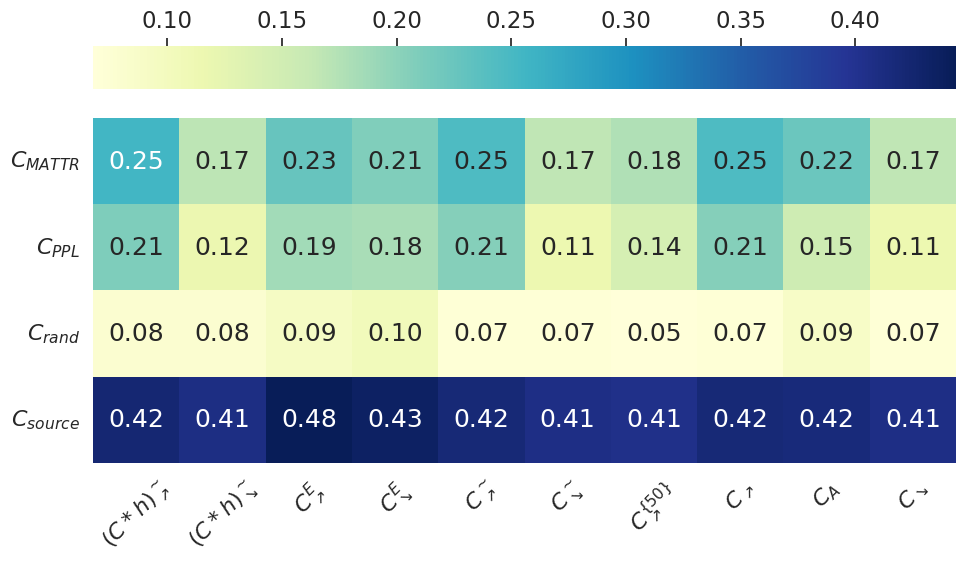

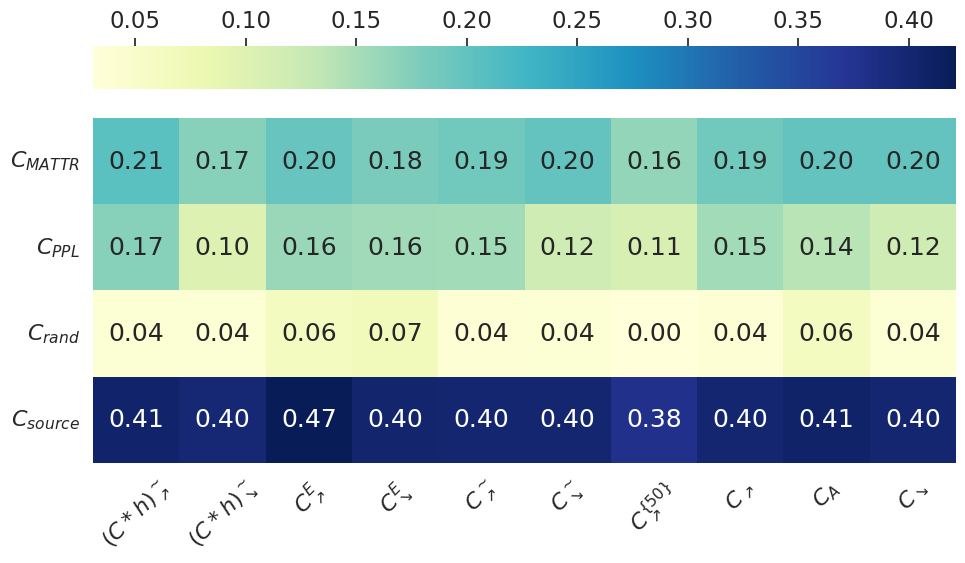

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

sns.set(font_scale=1.5)


model_types = stats_df["model_type"].unique()

for model_type in model_types:
    subset_df = stats_df[stats_df["model_type"] == model_type]

    pivot_df = subset_df.pivot_table(
        index="curriculum_a",
        columns="curriculum_b",
        values="divergence",
        aggfunc='mean'
    ).fillna(float('nan'))

    pivot_df = pivot_df.rename(index=util.rename, columns=util.rename)

    pivot_df = pivot_df.sort_index(axis=0).sort_index(axis=1)

    pivot_df = pivot_df[pivot_df.index.isin([util.rename(c) for c in config.baseline_curricula])]
    pivot_df = pivot_df[[col for col in pivot_df.columns if col not in [util.rename(c) for c in config.baseline_curricula]]]

  
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        pivot_df,
        annot=True,
        cmap="YlGnBu",
        fmt=".2f",
        cbar_kws=dict(use_gridspec=True, location="top", fraction=0.089, pad=0.04, ),
        cbar=True,
        robust=True
    )

   # plt.title(f"{model_type}", fontsize=18, fontweight="bold")
    plt.xlabel("", fontsize=16)
    plt.ylabel("", fontsize=16)

    plt.xticks(rotation=45, fontsize=16)
    plt.yticks(rotation=0, fontsize=16)
    plt.gca().set_facecolor("white")
    plt.gca().set_aspect('equal', 'box')

    plt.tight_layout()

    save_path = os.path.join("./autogenerated_figures", f"source_distribution_similarity_heatmap_{model_type}.pdf")
    plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()


curriculum_a,llama_incr_influence_epoch_repetition.pt,llama_influence_decr_bins_dirac.pt,llama_influence_decr_bins_lognorm.pt,llama_influence_decr_cp_dirac.pt,llama_influence_epoch_repetition.pt,llama_influence_incr_bins_dirac.pt,llama_influence_incr_bins_lognorm.pt,llama_influence_incr_cp_dirac.pt,llama_influence_top_50_cp_shuffled.pt,llama_influence_tracin_sandwich.pt,mattr_increasing.pt,perplexity_increasing.pt,random.pt,source_difficulty.pt
curriculum_b,,,,,,,,,,,,,,
llama_incr_influence_epoch_repetition.pt,0.000000,0.151543,0.156935,0.151563,0.227459,0.139288,0.144357,0.139308,0.096802,0.159360,0.227804,0.185337,0.093719,0.479888
llama_influence_decr_bins_dirac.pt,0.151543,0.000000,0.009288,0.000007,0.144932,0.218631,0.227889,0.218655,0.106007,0.102398,0.166145,0.114682,0.071844,0.408082
llama_influence_decr_bins_lognorm.pt,0.156935,0.009288,0.000000,0.009308,0.150188,0.227907,0.238011,0.227933,0.112014,0.102217,0.168633,0.117390,0.078927,0.409495
llama_influence_decr_cp_dirac.pt,0.151563,0.000007,0.009308,0.000000,0.144951,0.218643,0.227904,0.218668,0.106025,0.102423,0.166148,0.114707,0.071863,0.408092
llama_influence_epoch_repetition.pt,0.227459,0.144932,0.150188,0.144951,0.000000,0.147375,0.152807,0.147394,0.090884,0.158260,0.208146,0.181995,0.103538,0.433769
llama_influence_incr_bins_dirac.pt,0.139288,0.218631,0.227907,0.218643,0.147375,0.000000,0.009347,0.000007,0.106300,0.175480,0.246674,0.205362,0.071905,0.420320
llama_influence_incr_bins_lognorm.pt,0.144357,0.227889,0.238011,0.227904,0.152807,0.009347,0.000000,0.009360,0.112409,0.183114,0.254488,0.209465,0.078956,0.421989
llama_influence_incr_cp_dirac.pt,0.139308,0.218655,0.227933,0.218668,0.147394,0.000007,0.009360,0.000000,0.106322,0.175500,0.246692,0.205380,0.071929,0.420328
llama_influence_top_50_cp_shuffled.pt,0.096802,0.106007,0.112014,0.106025,0.090884,0.106300,0.112409,0.106322,0.000000,0.121030,0.177717,0.144233,0.052710,0.405304


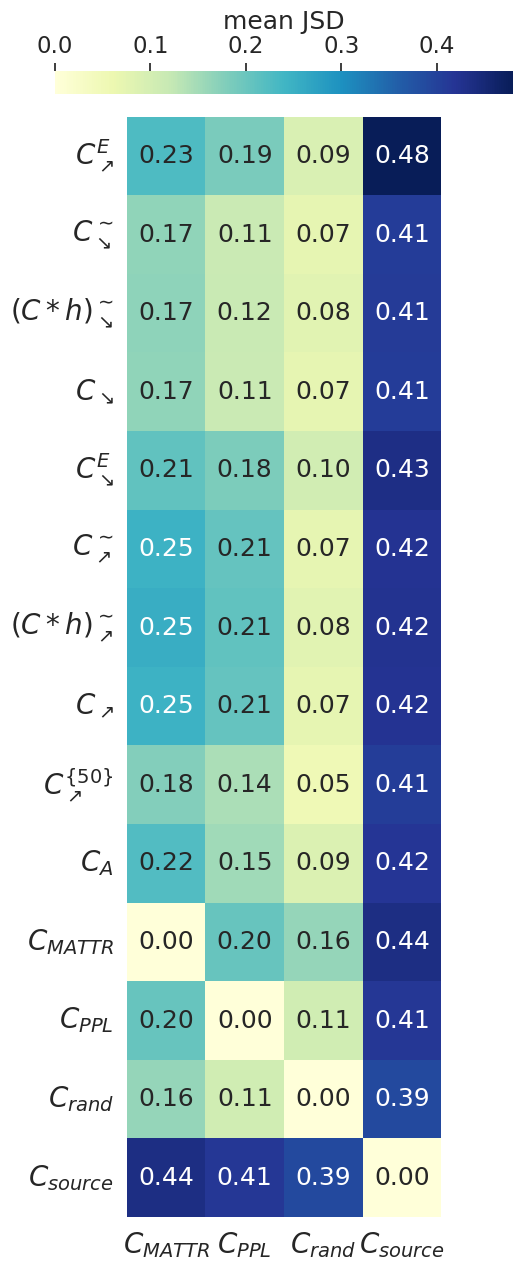

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm, Normalize


    

fig, ax = plt.subplots(figsize=(12, 14))
data = stats_df[stats_df["model_type"] == "llama"]
pivot_df = data.pivot_table(index="curriculum_b", 
                                columns="curriculum_a", 
                                values="divergence", 
                                aggfunc='mean',fill_value=np.nan)
display(pivot_df)

pivot_df = pivot_df.rename(index=util.rename, columns=util.rename)


pivot_df = pivot_df[pivot_df.index.isin([util.rename(c) for c in config.baseline_curricula])]

# pivot_df = pivot_df[[ (col not in [util.rename(c) for c in config.baseline_curricula])]]
pivot_df = pivot_df.T
mask = np.triu(np.ones_like(pivot_df, dtype=bool), k=1)
sns.heatmap(pivot_df, ax=ax, annot=True, cmap="YlGnBu", fmt=".2f", cbar=True, 
                    cbar_kws=dict(use_gridspec=True, location="top", fraction=0.02, pad=0.02,label=r"mean JSD"))

ax.set(xlabel="", ylabel="")

ax.tick_params(axis='y', rotation=0, which='major', labelsize=20)
ax.tick_params(axis='x', rotation=0, which='major', labelsize=20)

ax.set_xlabel(ax.get_xlabel(), fontsize=25)
ax.set_ylabel(ax.get_ylabel(), fontsize=25)
ax.set_aspect('equal', 'box')
ax.set_facecolor("white")
plt.tight_layout(pad=3)
plt.savefig(os.path.join("./autogenerated_figures", "source_distribution_llama.pdf"), dpi=600, bbox_inches='tight')

plt.show()


In [6]:
benchmark_results = pd.read_pickle("./plotting_notebooks/cache/benchmark_results.pkl")
df = stats_df.copy()
df["curriculum_b"] = df["curriculum_b"].apply(util.rename)
df["dataset"] = df["dataset"].apply(util.rename_dataset)
df["model_type"] = df["model_type"].str.lower()
benchmark_results["model_type"] = benchmark_results["model_type"].str.lower()
df = df[df["curriculum_a"] == "random.pt"]
df = pd.merge(df, benchmark_results, left_on=["curriculum_b", "model_type","dataset"], right_on=["model", "model_type","dataset"])
df["group"] = df["curriculum_b"].apply(lambda x: ("sorted_decreasing_influence" if "searrow" in x else "sorted_increasing_influence") if ("arrow" in x) and ("E" not in x) and ("A" not in x) and ("50" not in x) else "other")

In [7]:
df

,chunk,curriculum_a,curriculum_b,dataset,model_type,chunk_size_a,chunk_size_b,divergence,model,model_acc,random_acc,p_value,average_improvement,significant,average_improvement_source_difficulty,formatted_improvement,curriculum,group
0,0,random.pt,$C^E_{\nearrow}$,$D_{equitoken}$,llama,1000,1000,0.118305,$C^E_{\nearrow}$,0.472962,0.523169,0.032952,-5.020654,True,-4.904843,-5.02 pp**,$C^E_{\nearrow}$,other
1,1,random.pt,$C^E_{\nearrow}$,$D_{equitoken}$,llama,1000,1000,0.129946,$C^E_{\nearrow}$,0.472962,0.523169,0.032952,-5.020654,True,-4.904843,-5.02 pp**,$C^E_{\nearrow}$,other
2,2,random.pt,$C^E_{\nearrow}$,$D_{equitoken}$,llama,1000,1000,0.137309,$C^E_{\nearrow}$,0.472962,0.523169,0.032952,-5.020654,True,-4.904843,-5.02 pp**,$C^E_{\nearrow}$,other
3,3,random.pt,$C^E_{\nearrow}$,$D_{equitoken}$,llama,1000,1000,0.123812,$C^E_{\nearrow}$,0.472962,0.523169,0.032952,-5.020654,True,-4.904843,-5.02 pp**,$C^E_{\nearrow}$,other
4,4,random.pt,$C^E_{\nearrow}$,$D_{equitoken}$,llama,1000,1000,0.146398,$C^E_{\nearrow}$,0.472962,0.523169,0.032952,-5.020654,True,-4.904843,-5.02 pp**,$C^E_{\nearrow}$,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83967,995,random.pt,$C^E_{\nearrow}$,$D_{2024}$,roberta,11790,11790,0.226805,$C^E_{\nearrow}$,0.495878,0.465683,0.124232,3.019464,False,-8.751359,+3.02 pp,$C^E_{\nearrow}$,other
83968,996,random.pt,$C^E_{\nearrow}$,$D_{2024}$,roberta,11790,11790,0.220072,$C^E_{\nearrow}$,0.495878,0.465683,0.124232,3.019464,False,-8.751359,+3.02 pp,$C^E_{\nearrow}$,other
83969,997,random.pt,$C^E_{\nearrow}$,$D_{2024}$,roberta,11790,11790,0.223326,$C^E_{\nearrow}$,0.495878,0.465683,0.124232,3.019464,False,-8.751359,+3.02 pp,$C^E_{\nearrow}$,other
83970,998,random.pt,$C^E_{\nearrow}$,$D_{2024}$,roberta,11790,11790,0.217983,$C^E_{\nearrow}$,0.495878,0.465683,0.124232,3.019464,False,-8.751359,+3.02 pp,$C^E_{\nearrow}$,other


In [8]:
df[df["group"] != "other"].groupby([ "dataset","group"])["divergence"].corr(df["model_acc"])

dataset           group                      
$D_{2024}$        sorted_decreasing_influence    0.050694
                  sorted_increasing_influence   -0.281950
$D_{equitoken}$   sorted_decreasing_influence   -0.009128
                  sorted_increasing_influence    0.134388
$D_{stratified}$  sorted_decreasing_influence   -0.093960
                  sorted_increasing_influence   -0.165533
Name: divergence, dtype: float64

In [9]:
from scipy.stats import pearsonr
filtered_df = df[df["group"] != "other"]

def compute_corr(subdf):
    return subdf["divergence"].corr(subdf["model_acc"])

correlations = filtered_df.groupby(["dataset", "group"]).apply(compute_corr)
def corr_with_p(subdf):
    if len(subdf) < 2:
        return pd.Series({"corr": None, "pval": None})
    corr, pval = pearsonr(subdf["divergence"], subdf["model_acc"])
    return pd.Series({"corr": corr, "pval": pval})

results = filtered_df.groupby(["dataset","model_type", "group"]).apply(corr_with_p)
results

/tmp/ipykernel_235913/3739174130.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = filtered_df.groupby(["dataset", "group"]).apply(compute_corr)
/tmp/ipykernel_235913/3739174130.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = filtered_df.groupby(["dataset","model_type", "group"]).apply(corr_with_p)


corr  \
dataset          model_type group                                   
$D_{2024}$       llama      sorted_decreasing_influence  0.073024   
                            sorted_increasing_influence -0.076430   
                 roberta    sorted_decreasing_influence  0.113108   
                            sorted_increasing_influence -0.120587   
$D_{equitoken}$  llama      sorted_decreasing_influence -0.101120   
                            sorted_increasing_influence -0.084303   
                 roberta    sorted_decreasing_influence  0.000202   
                            sorted_increasing_influence -0.000078   
$D_{stratified}$ llama      sorted_decreasing_influence -0.010824   
                            sorted_increasing_influence -0.000461   
                 roberta    sorted_decreasing_influence -0.210345   
                            sorted_increasing_influence -0.241064   

                                                                 pval  
dataset          model_type group                                      
$D_{2024}$       llama      sorted_decreasing_influence  6.245296e-05  
                            sorted_increasing_influence  2.781674e-05  
                 roberta    sorted_decreasing_influence  5.213889e-10  
                            sorted_increasing_influence  3.442458e-11  
$D_{equitoken}$  llama      sorted_decreasing_influence  2.894226e-08  
                            sorted_increasing_influence  3.810290e-06  
                 roberta    sorted_decreasing_influence  9.911951e-01  
                            sorted_increasing_influence  9.966011e-01  
$D_{stratified}$ llama      sorted_decreasing_influence  5.534223e-01  
                            sorted_increasing_influence  9.798478e-01  
                 roberta    sorted_decreasing_influence  2.381908e-31  
                            sorted_increasing_influence  6.367035e-41

In [10]:
from scipy.stats import pearsonr
import pandas as pd

filtered_df = df#df[df["group"] != "other"]

def compute_corr(subdf):
    return subdf["divergence"].corr(subdf["average_improvement"])


correlations = filtered_df.groupby(["dataset", "group"]).apply(compute_corr)

def corr_with_p(subdf):
    if len(subdf) < 2:
        return pd.Series({"corr": None, "pval": None, "significant": "no", "corr_strength": None})
    corr, pval = pearsonr(subdf["divergence"], subdf["average_improvement"])
    

    significant = "yes" if pval < 0.05 else "no"
    

    if abs(corr) >= 0.9:
        corr_strength = "very strong"
    elif abs(corr) >= 0.7:
        corr_strength = "strong"
    elif abs(corr) >= 0.4:
        corr_strength = "moderate"
    elif abs(corr) >= 0.2:
        corr_strength = "weak"
    else:
        corr_strength = "very weak"
    
    return pd.Series({"corr": corr, "pval": pval, "significant": significant, "corr_strength": corr_strength})

results = filtered_df.groupby(["dataset", "group"]).apply(corr_with_p)

results.style.format({
    'corr': '{:.3f}',   
    'pval': '{:.3f}'    
})


/tmp/ipykernel_235913/4131098713.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = filtered_df.groupby(["dataset", "group"]).apply(compute_corr)
/tmp/ipykernel_235913/4131098713.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = filtered_df.groupby(["dataset", "group"]).apply(corr_with_p)


In [11]:
from scipy.stats import pearsonr
import pandas as pd

filtered_df = df#df[df["group"] != "other"]

def compute_corr(subdf):
    return subdf["divergence"].corr(subdf["average_improvement"])


correlations = filtered_df.groupby(["dataset"]).apply(compute_corr)

def corr_with_p(subdf):
    if len(subdf) < 2:
        return pd.Series({"corr": None, "pval": None, "significant": "no", "corr_strength": None})
    corr, pval = pearsonr(subdf["divergence"], subdf["average_improvement"])
    

    significant = "yes" if pval < 0.05 else "no"
    

    if abs(corr) >= 0.9:
        corr_strength = "very strong"
    elif abs(corr) >= 0.7:
        corr_strength = "strong"
    elif abs(corr) >= 0.4:
        corr_strength = "moderate"
    elif abs(corr) >= 0.2:
        corr_strength = "weak"
    else:
        corr_strength = "very weak"
    
    return pd.Series({"corr": corr, "pval": pval, "significant": significant, "corr_strength": corr_strength})

results = filtered_df.groupby(["dataset","model_type"]).apply(corr_with_p)

results.style.format({
    'corr': '{:.3f}',   
    'pval': '{:.3f}'    
})


/tmp/ipykernel_235913/1426862545.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = filtered_df.groupby(["dataset"]).apply(compute_corr)
/tmp/ipykernel_235913/1426862545.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = filtered_df.groupby(["dataset","model_type"]).apply(corr_with_p)


In [12]:
from scipy.stats import pearsonr
import pandas as pd

filtered_df = df[df["group"] != "other"]

def compute_corr(subdf):
    return subdf["divergence"].corr(subdf["average_improvement"])


correlations = filtered_df.groupby(["dataset", "group"]).apply(compute_corr)

def corr_with_p(subdf):
    if len(subdf) < 2:
        return pd.Series({"corr": None, "pval": None, "significant": "no", "corr_strength": None})
    corr, pval = pearsonr(subdf["divergence"], subdf["average_improvement"])
    

    significant = "yes" if pval < 0.05 else "no"
    

    if abs(corr) >= 0.9:
        corr_strength = "very strong"
    elif abs(corr) >= 0.7:
        corr_strength = "strong"
    elif abs(corr) >= 0.4:
        corr_strength = "moderate"
    elif abs(corr) >= 0.2:
        corr_strength = "weak"
    else:
        corr_strength = "very weak"
    
    return pd.Series({"corr": corr, "pval": pval, "significant": significant, "corr_strength": corr_strength})

results = filtered_df.groupby(["dataset"]).apply(corr_with_p)

results.style.format({
    'corr': '{:.3f}',   
    'pval': '{:.3f}'    
})


/tmp/ipykernel_235913/205531281.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = filtered_df.groupby(["dataset", "group"]).apply(compute_corr)
/tmp/ipykernel_235913/205531281.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = filtered_df.groupby(["dataset"]).apply(corr_with_p)


,corr,pval,significant,corr_strength
dataset,,,,
$D_{2024}$,-0.504,0.000,yes,moderate
$D_{equitoken}$,-0.370,0.000,yes,weak
$D_{stratified}$,-0.021,0.022,yes,very weak
